In [16]:
# Import libraries

import numpy              as np
import matplotlib.pyplot  as plt
import matplotlib.patches as patches
import emcee
from   scipy              import stats
from   scipy.stats        import norm

In [17]:
# Use LaTeX, set matplotlib plots resolution to decent

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"]
})

%matplotlib inline 
plt.rcParams['figure.dpi'] = 300

# the event function as a LaTeX string for titles and so on
latexfunc = r'$ f(t) = ' \
          + r'\left\{ \begin{array}{ll}' \
          + r'b & \textup{if } \; t < t_0 \\' \
          + r'b + A \, e^{-\alpha(t - t_0)} & \textup{if } \; t \geq t_0' \
          + r'\end{array} \right. $'

In [18]:
# define all the functions

# our model for the transient event is:   f(t) =  t > t0 : b  ;  t <= t0 : b + A e^( -a(t-t0) )
# the unknown parameters are:                x = [a, b, A, t0] 
# the functional shape f(t;x) of the transient event:

def event(x, t):  
    return np.where( t > x[3] , x[1] + x[2] * np.exp( -x[0]*(t-x[3]) ) , x[1] )

# the chosen priors on the parameters x:   # SOMETHING IS WRONG

def prior(x): 
    prior_a  = stats.loguniform.pdf(x[0], -5, 5)         # if -5 < lna < +5  returns 1/a,   0 if else  # np.exp( stats.uniform.pdf(np.log(x[0]), loc=-5, scale=5) ) / x[0]
    prior_b  = stats.uniform.pdf(x[1], loc=0, scale=50 ) # if  0 < b   < 50  returns 1/50,  0 if else
    prior_A  = stats.uniform.pdf(x[2], loc=0, scale=50 ) # if  0 < c   < 50  returns 1/50,  0 if else
    prior_t0 = stats.uniform.pdf(x[3], loc=0, scale=100) # if  0 < t0  < 100 returns 1/100, 0 if else
    return prior_a * prior_b * prior_A * prior_t0

# likelihood = prod_data   exp( -1/2 ( f_data - f(t_data) )^2 / f_err^2 ) * const
# the likelihood function given the data: t, f; remember homoscedastic errors: ef.

def likelihood(x, t, f, ef):                               
    return np.prod( np.exp( 1/2 * ( f - event(x, t) )**2 / ef**2 ) ) 

# the posterior pdf: multiply the likelihood by the priors.

def posterior(x, t, f, ef):                                       
    return likelihood(x, t, f, ef) * prior(x)

# Do this again but directly with the logs:

# logarithm of the prior of the parameters x:

def log_prior(x):
    if -5 < np.log(x[0]) < 5 and 0 < x[1] < 50 and 0 < x[2] < 50 and 0 < x[3] < 100 :
        return 0.
    return -np.inf

# logarithm of the posterior pdf:

def logposter(x, t, f, ef):
    return  - 1/2 * np.sum( ( f - event(x, t) )**2 / ef**2 + np.log(ef**2) ) + log_prior(x)


wrong = '''
def logposter(x, t, f, ef):
    logprior = np.log( prior(x) )
    if not np.isfinite(logprior): # if log(prior) is infinite (if prior is 0), return -infinity
        return -np.inf
    return  - 1/2 * np.sum( ( f - event(x, t) )**2 / ef**2 + np.log(ef**2) ) + logprior
'''

In [19]:
# Load data

data = np.load('transient.npy')

T  = data[:,0]
F  = data[:,1]
eF = data[:,2]

del data

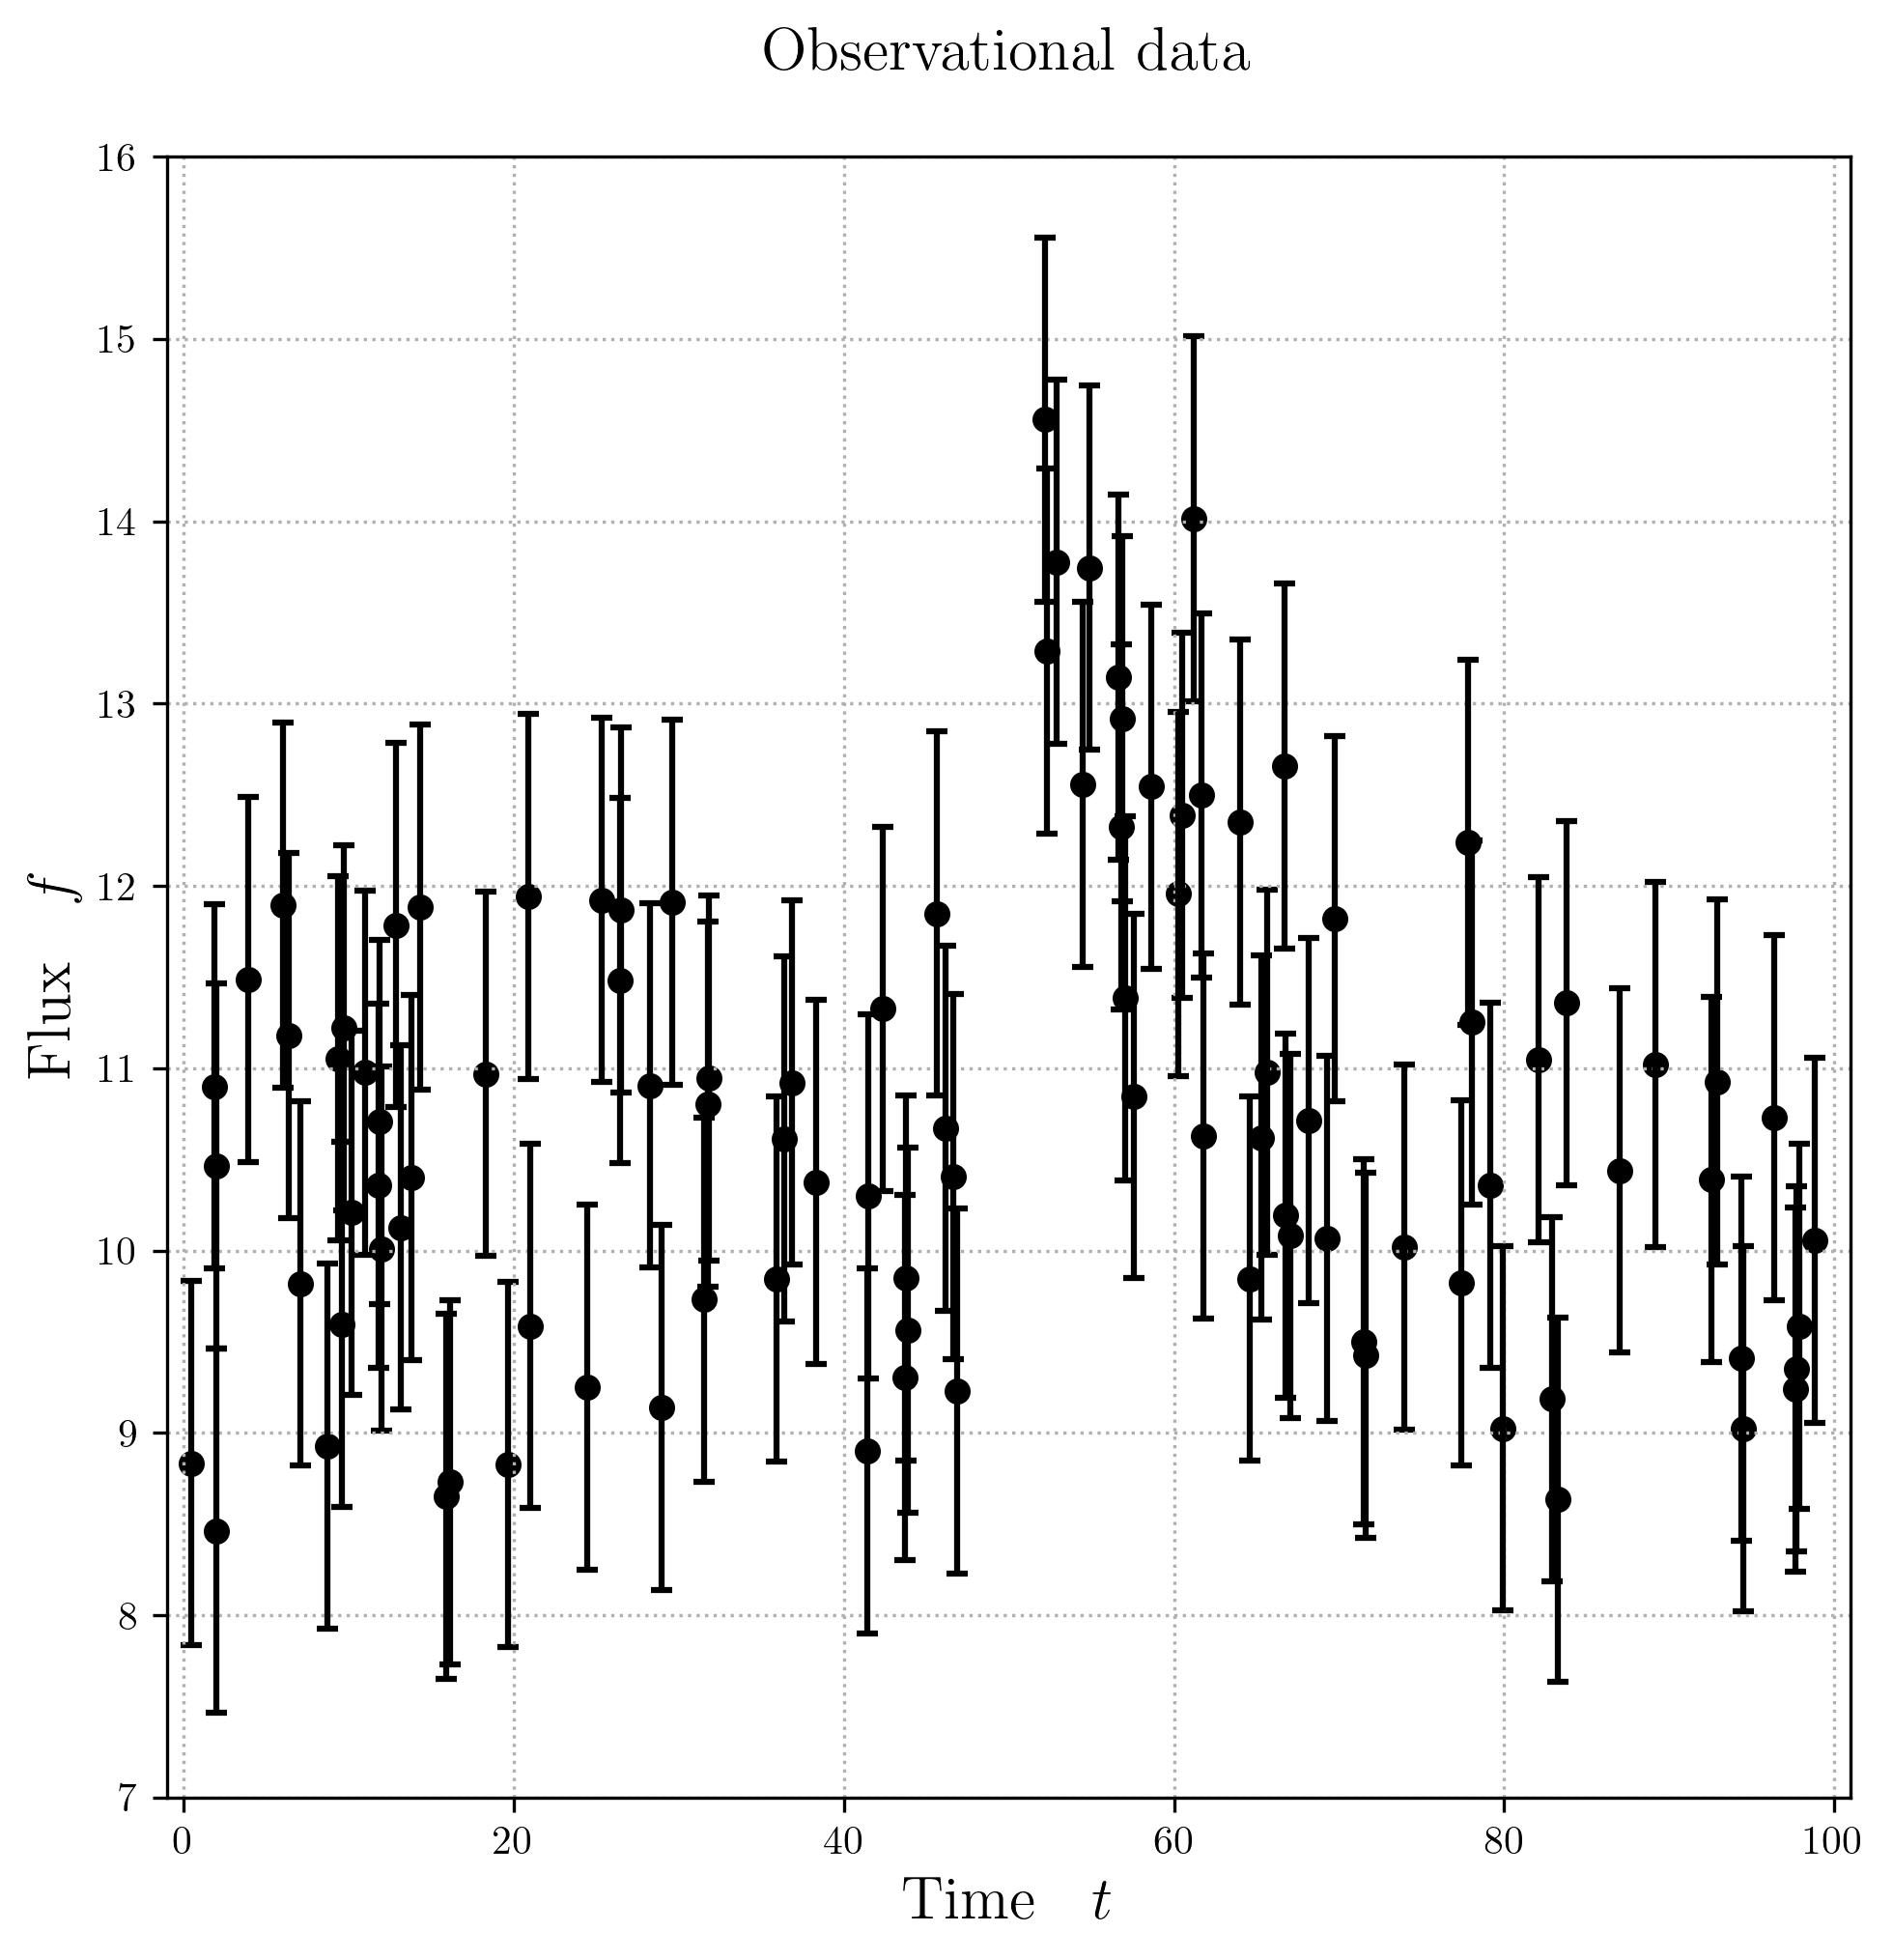

In [20]:
# Take a look at the data

fig , ax = plt.subplots(figsize=(7.5,7.5))

ax.set_xlim(-1,101)
ax.set_ylim(7,16)
ax.grid(ls=':')
ax.set_title('Observational data' + '\n', fontsize=15)
ax.set_xlabel(r'Time \; $t$', fontsize=15)
ax.set_ylabel(r'Flux \; $f$', fontsize=15)   # , rotation='horizontal', labelpad=20


for i in range(len(T)):                                                       #for t, f, ef in zip(T, F, eF):
    ax.vlines(T[i], ymin=F[i]-eF[i], ymax=F[i]+eF[i], color='black' )          #ax.vlines( t, ymin=t-ef, ymax=t+ef)
ax.scatter(T, F + eF, color='black', s=30, marker='_')
ax.scatter(T, F - eF, color='black', s=30, marker='_')
ax.scatter(T, F, color='black', s=30, marker='o') # , label='')

x0 = np.array( [0.1,10,5,50] )
t_lin = np.linspace(0,100, 10000)
y_lin = event(x0, t_lin)

# ax.plot(t_lin, y_lin, color='lightskyblue')

In [27]:
# Monte Carlo Markov Chain

# number of model parameters x
n_dim     = 4     

# number of MCMC walkers
n_walkers = 24

# number of MCMC steps to take for each walker
n_steps   = 10000  

# initialize parameters x as: x0 + random(0,0.1) * x0
x0 = np.array( [0.1,10,5,50] )
starting_guesses = np.tile( x0, (n_walkers,1) )
for i in range(n_walkers):
    for j in range(n_dim):
        starting_guesses[i,j] += x0[j] * np.random.random() / 10.

# run the actual MCMC to sample the log posterior
sampler = emcee.EnsembleSampler(n_walkers, n_dim, logposter, args=(T,F,eF))
sampler.run_mcmc(starting_guesses, n_steps, progress=True)

print('ok')

  1%|█                                                                           | 134/10000 [00:00<00:07, 1339.23it/s]C:\Users\andre\AppData\Local\Temp\ipykernel_12936\818863027.py:35: RuntimeWarning: invalid value encountered in log
  if -5 < np.log(x[0]) < 5 and 0 < x[1] < 50 and 0 < x[2] < 50 and 0 < x[3] < 100 :
100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1469.78it/s]

ok


In [71]:
# Choose how to adjust the MCMC results: burn-in, thinning, flattening

# autocorrelation length (ACL) for each parameter:
ACL = sampler.get_autocorr_time()

#  we can set the burn-in as a multiple of max(ACL) = maximum of the n_dim ACLs, and the thinning as max(ACL)
maxACL = int( np.amax(ACL) )

# burn-in period to let chains stabilize
n_burnin = 5 * maxACL

# thinning:
n_thin = maxACL

Text(0.5, 0, 'Markov Chain steps per walker, 24 walkers')

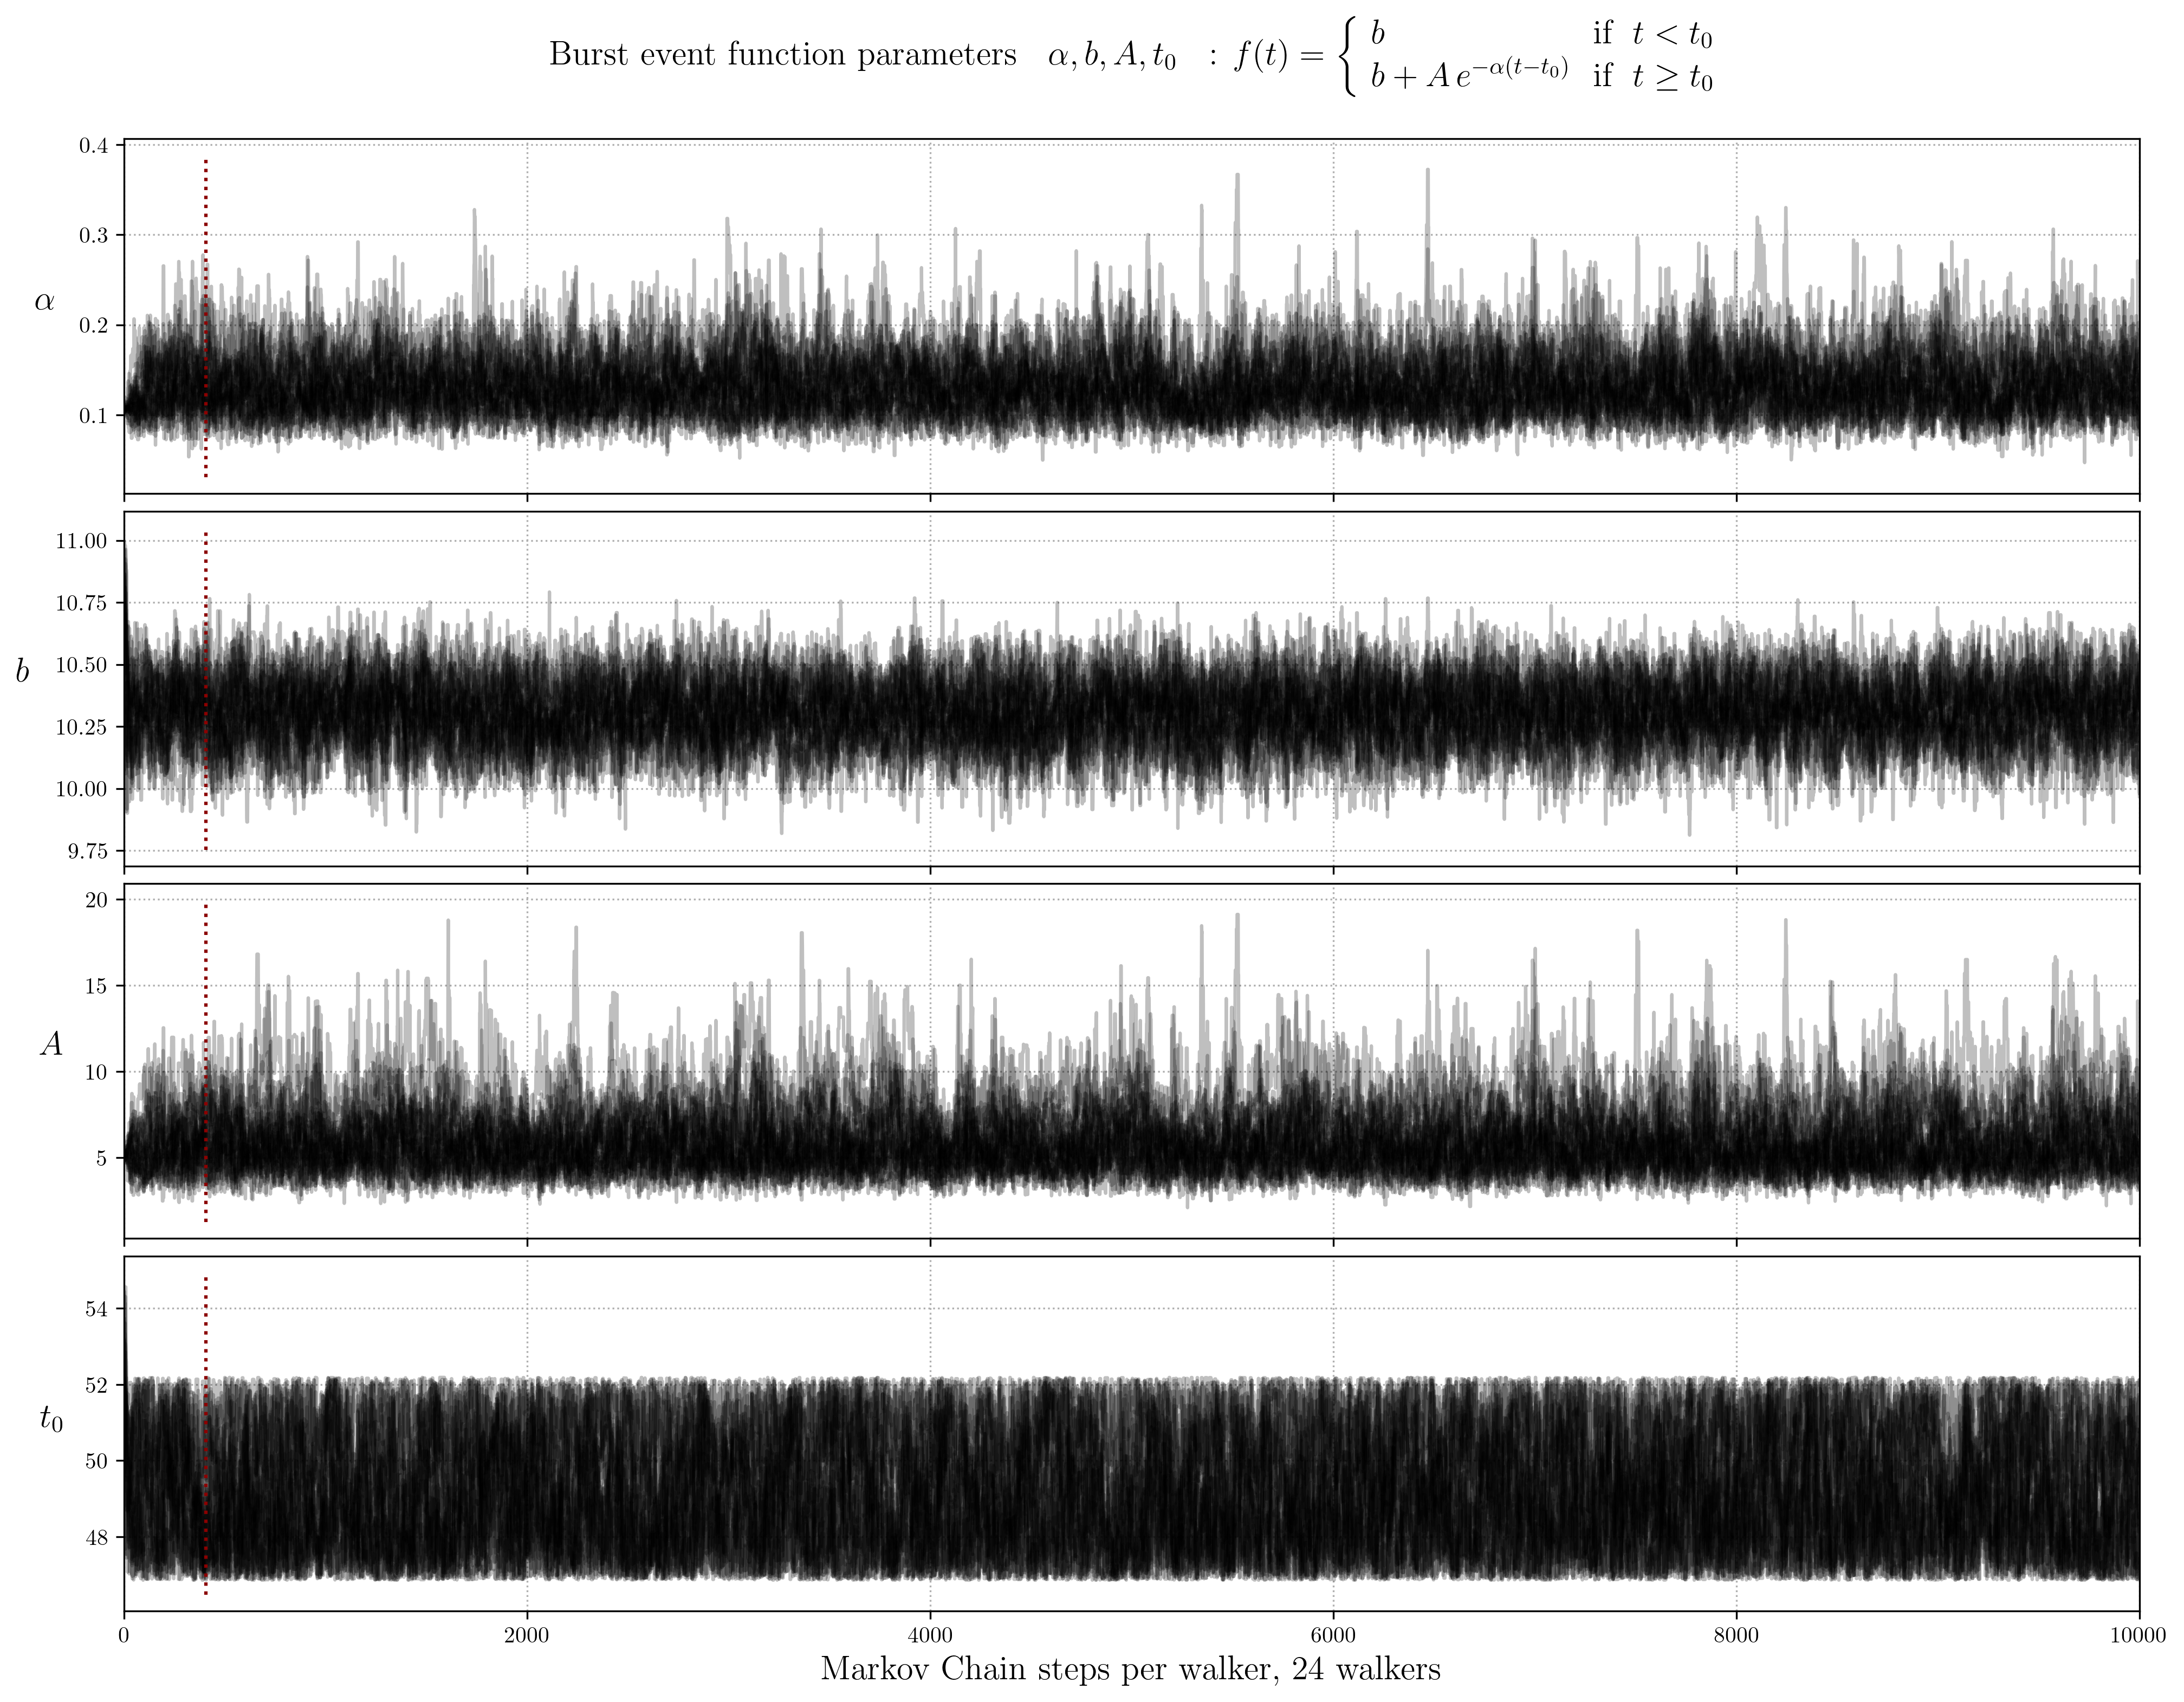

In [72]:
# Plot the results for the MCMC, before adjusting it:

MCMC_trace = sampler.chain[:,:,:]

fig , ax = plt.subplots(4,1, figsize=(16,12), sharex=True)

ax = ax.reshape(4)

fig.subplots_adjust(hspace=0.05)

M = np.size(MCMC_trace[:,0])
# chain_a  = MCMC_trace[:,0]
# chain_b  = MCMC_trace[:,1]
# chain_c  = MCMC_trace[:,2]
# chain_t0 = MCMC_trace[:,3]

xlabel  = 'steps'
ylabels = [r'$\alpha$', r'$b$', r'$A$', r'$t_0$' ]

MCtitle = r'Burst event function parameters \; $\alpha, b, A, t_0 $ \; : ' + latexfunc + '\n'
ax[0].set_title(MCtitle, fontsize=15)

for i in range(n_dim):
    ax[i].set_xlim(0, n_steps)
    ax[i].grid(ls=':')
    ax[i].set_ylabel( ylabels[i], fontsize=15, rotation='horizontal', labelpad=15)
    for j in range(n_walkers):
        ax[i].plot(MCMC_trace[j, :, i], color='black', alpha=0.25) # plotting also the burned-in ones (before red vline)
    ymin, ymax = ax[i].get_ylim()
    ax[i].vlines(n_burnin, ymin=ymin, ymax=ymax, color='darkred', ls=':')

ax[3].set_xlabel('Markov Chain steps per walker, {:d} walkers'.format(n_walkers), fontsize=15)

# fig.savefig('L11_MCMC_Ugly_Max.pdf', bbox_inches='tight')

In [73]:
# Now the actual adjustment:
# the shape of sampler.chain is (n_walkers, n_steps, n_dim); throw-out the burn-in points, reshape:

MCMC_trace = sampler.chain[:,n_burnin::n_thin,:].reshape(-1, n_dim)
print(MCMC_trace.shape) 

# analogous way:
# MCMC_trace = sampler.get_chain(discard=n_burnin, thin=n_thin, flat=True)
# print(MCMC_trace.shape)

(2856, 4)


Text(0.5, 0, 'Markov Chain after adjusting the sample')

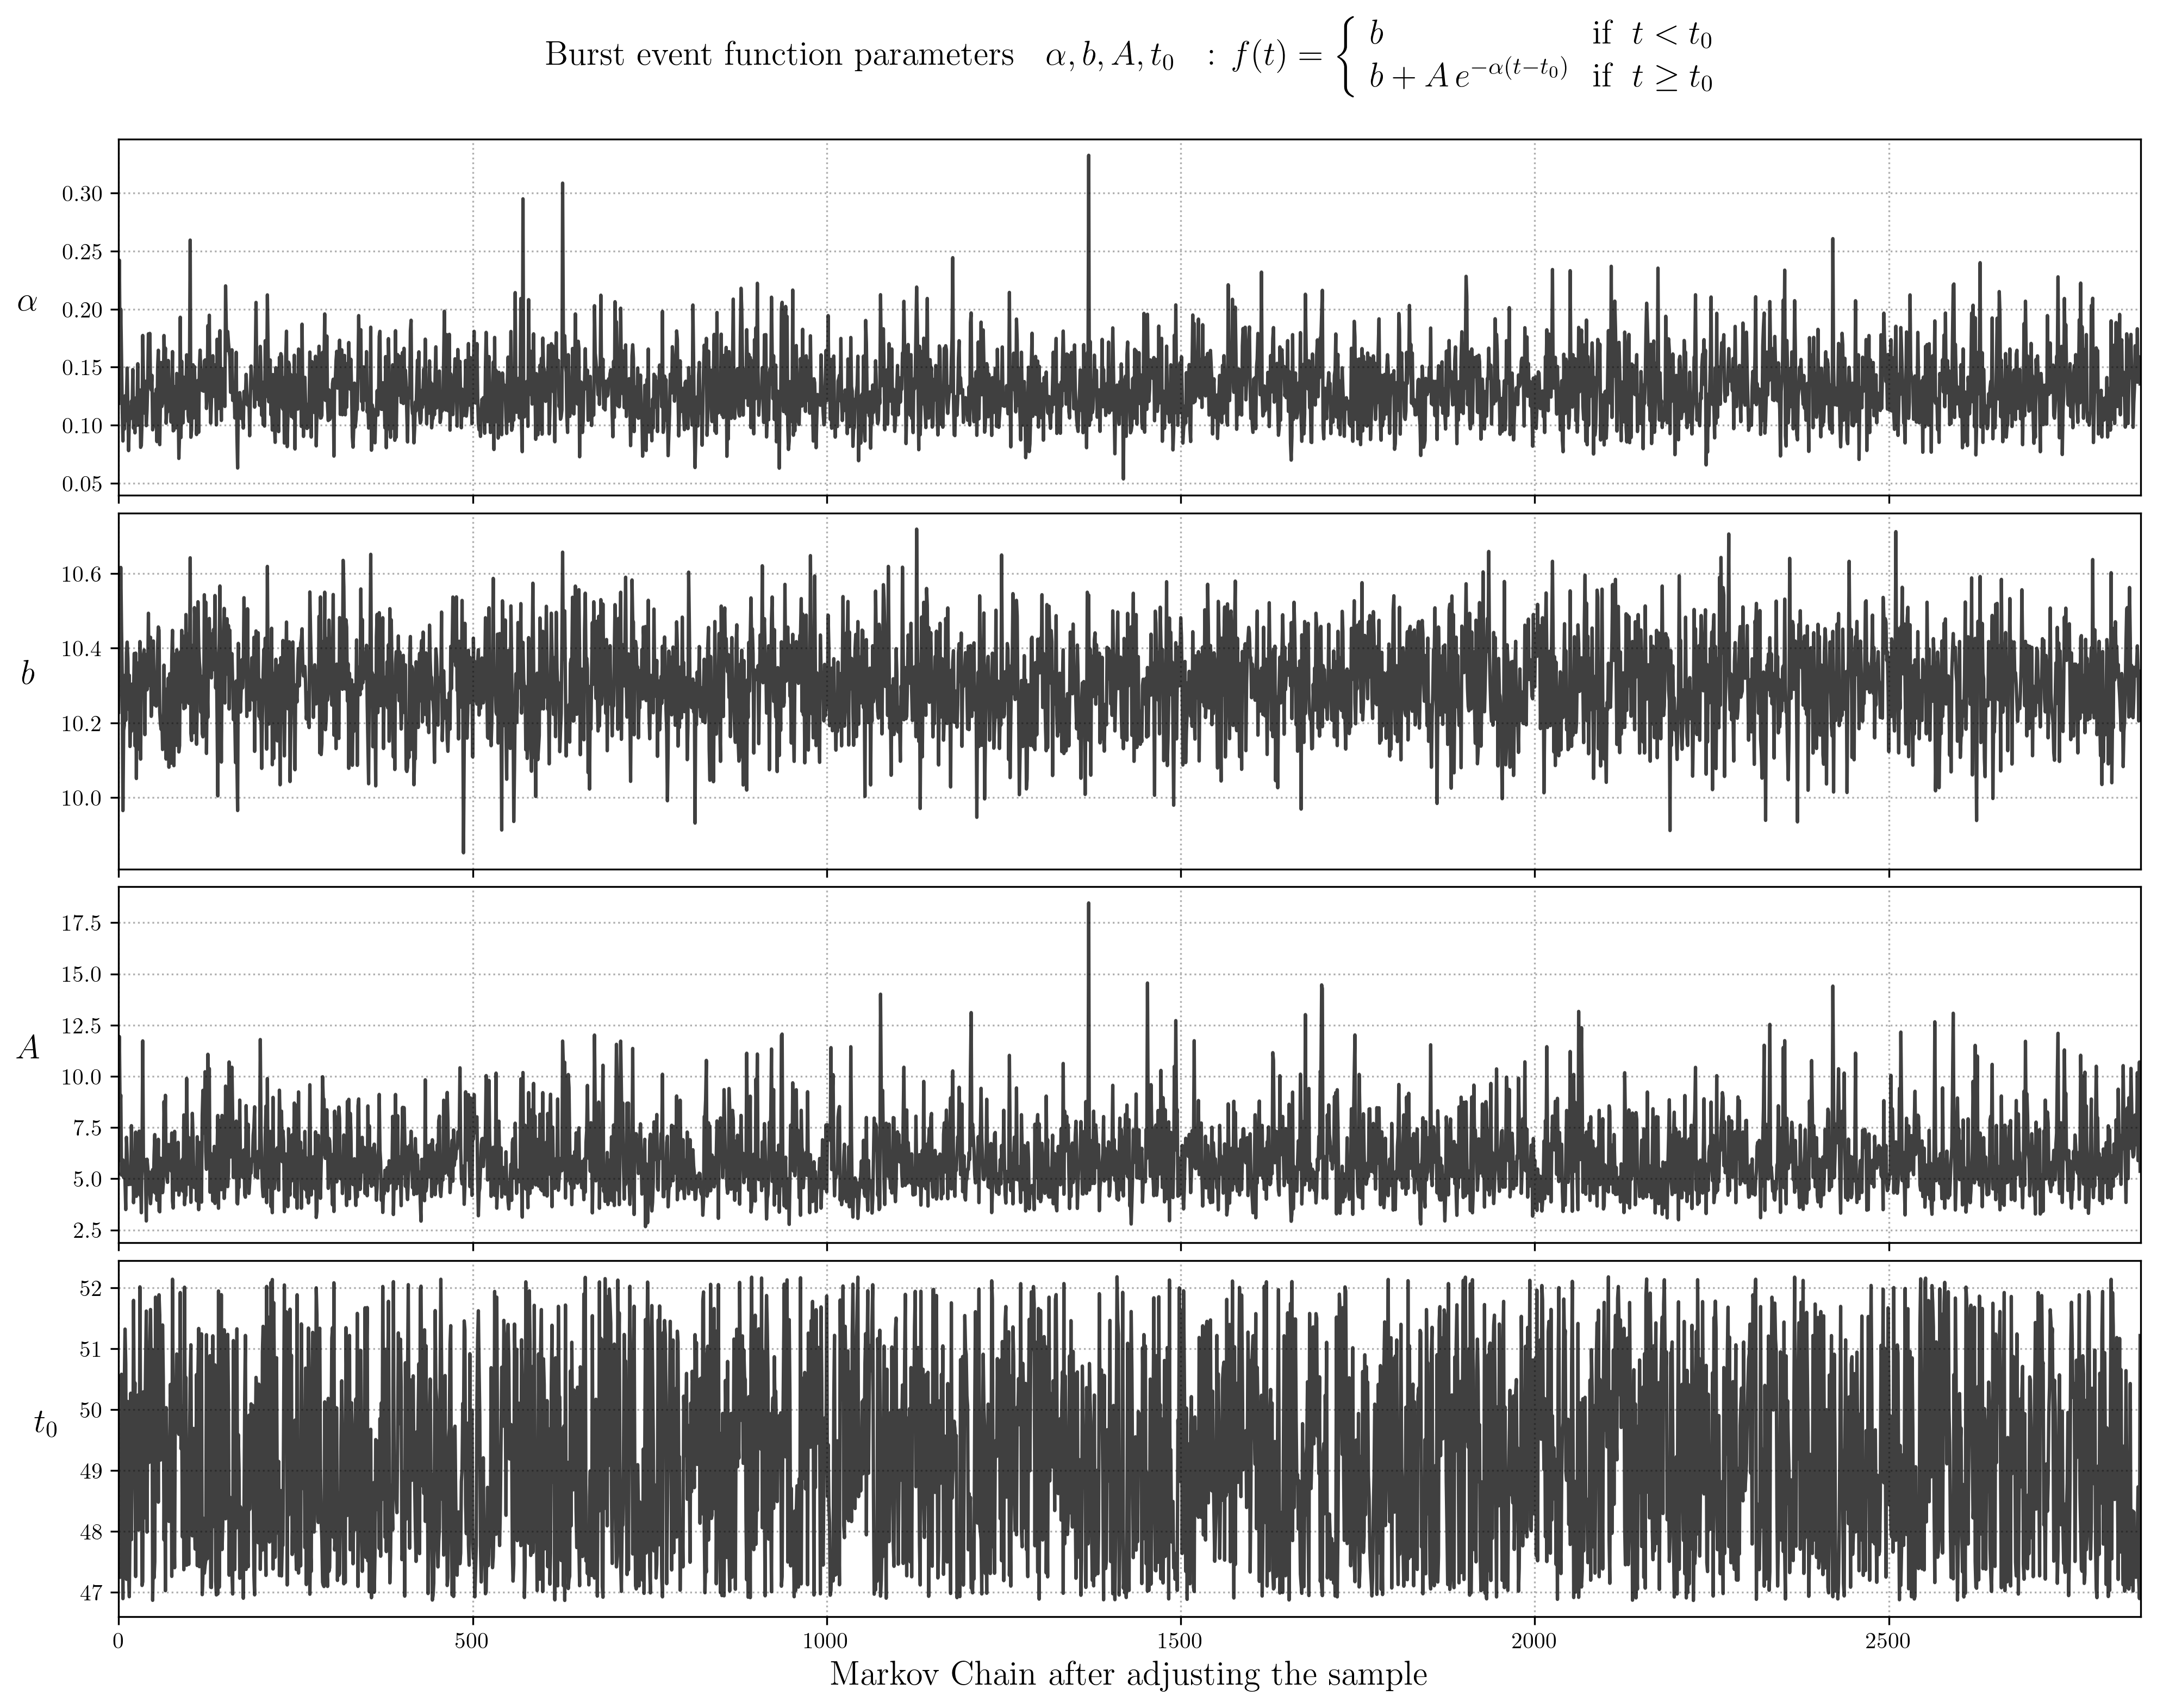

In [74]:
# Plot the results for the MCMC after burn-in, thinning, flattening:

fig , ax = plt.subplots(4,1, figsize=(16,12), sharex=True)

ax = ax.reshape(4)

fig.subplots_adjust(hspace=0.05)

M = np.size(MCMC_trace[:,0])
# chain_a  = MCMC_trace[:,0]
# chain_b  = MCMC_trace[:,1]
# chain_c  = MCMC_trace[:,2]
# chain_t0 = MCMC_trace[:,3]

xlabel  = 'steps'
ylabels = [r'$\alpha$', r'$b$', r'$A$', r'$t_0$' ]

MCtitle = r'Burst event function parameters \; $\alpha, b, A, t_0 $ \; : ' + latexfunc + '\n'
ax[0].set_title(MCtitle, fontsize=15)

for i in range(n_dim):
    # counts, bins, _ = ax[i].hist(MCMC_trace[:,i], bins=10, density=True, color='lightskyblue', histtype='step')
    ax[i].set_xlim(0,M)
    ax[i].plot(MCMC_trace[:,i], color='black', alpha=0.75)
    ax[i].grid(ls=':')
    ax[i].set_ylabel( ylabels[i], fontsize=15, rotation='horizontal', labelpad=15)

ax[3].set_xlabel('Markov Chain after adjusting the sample'.format(n_walkers), fontsize=15)

# fig.savefig('L11_MCMC_Clean_Max.pdf', bbox_inches='tight')

[[ 0.08989485 10.10509437  3.70414813 47.05035265]
 [ 0.104072   10.18585068  4.34602649 47.45941477]
 [ 0.12853865 10.3049329   5.62209266 49.06922093]
 [ 0.15962145 10.42333855  7.604065   50.9867333 ]
 [ 0.18274603 10.50556572  9.24647869 51.78187862]]


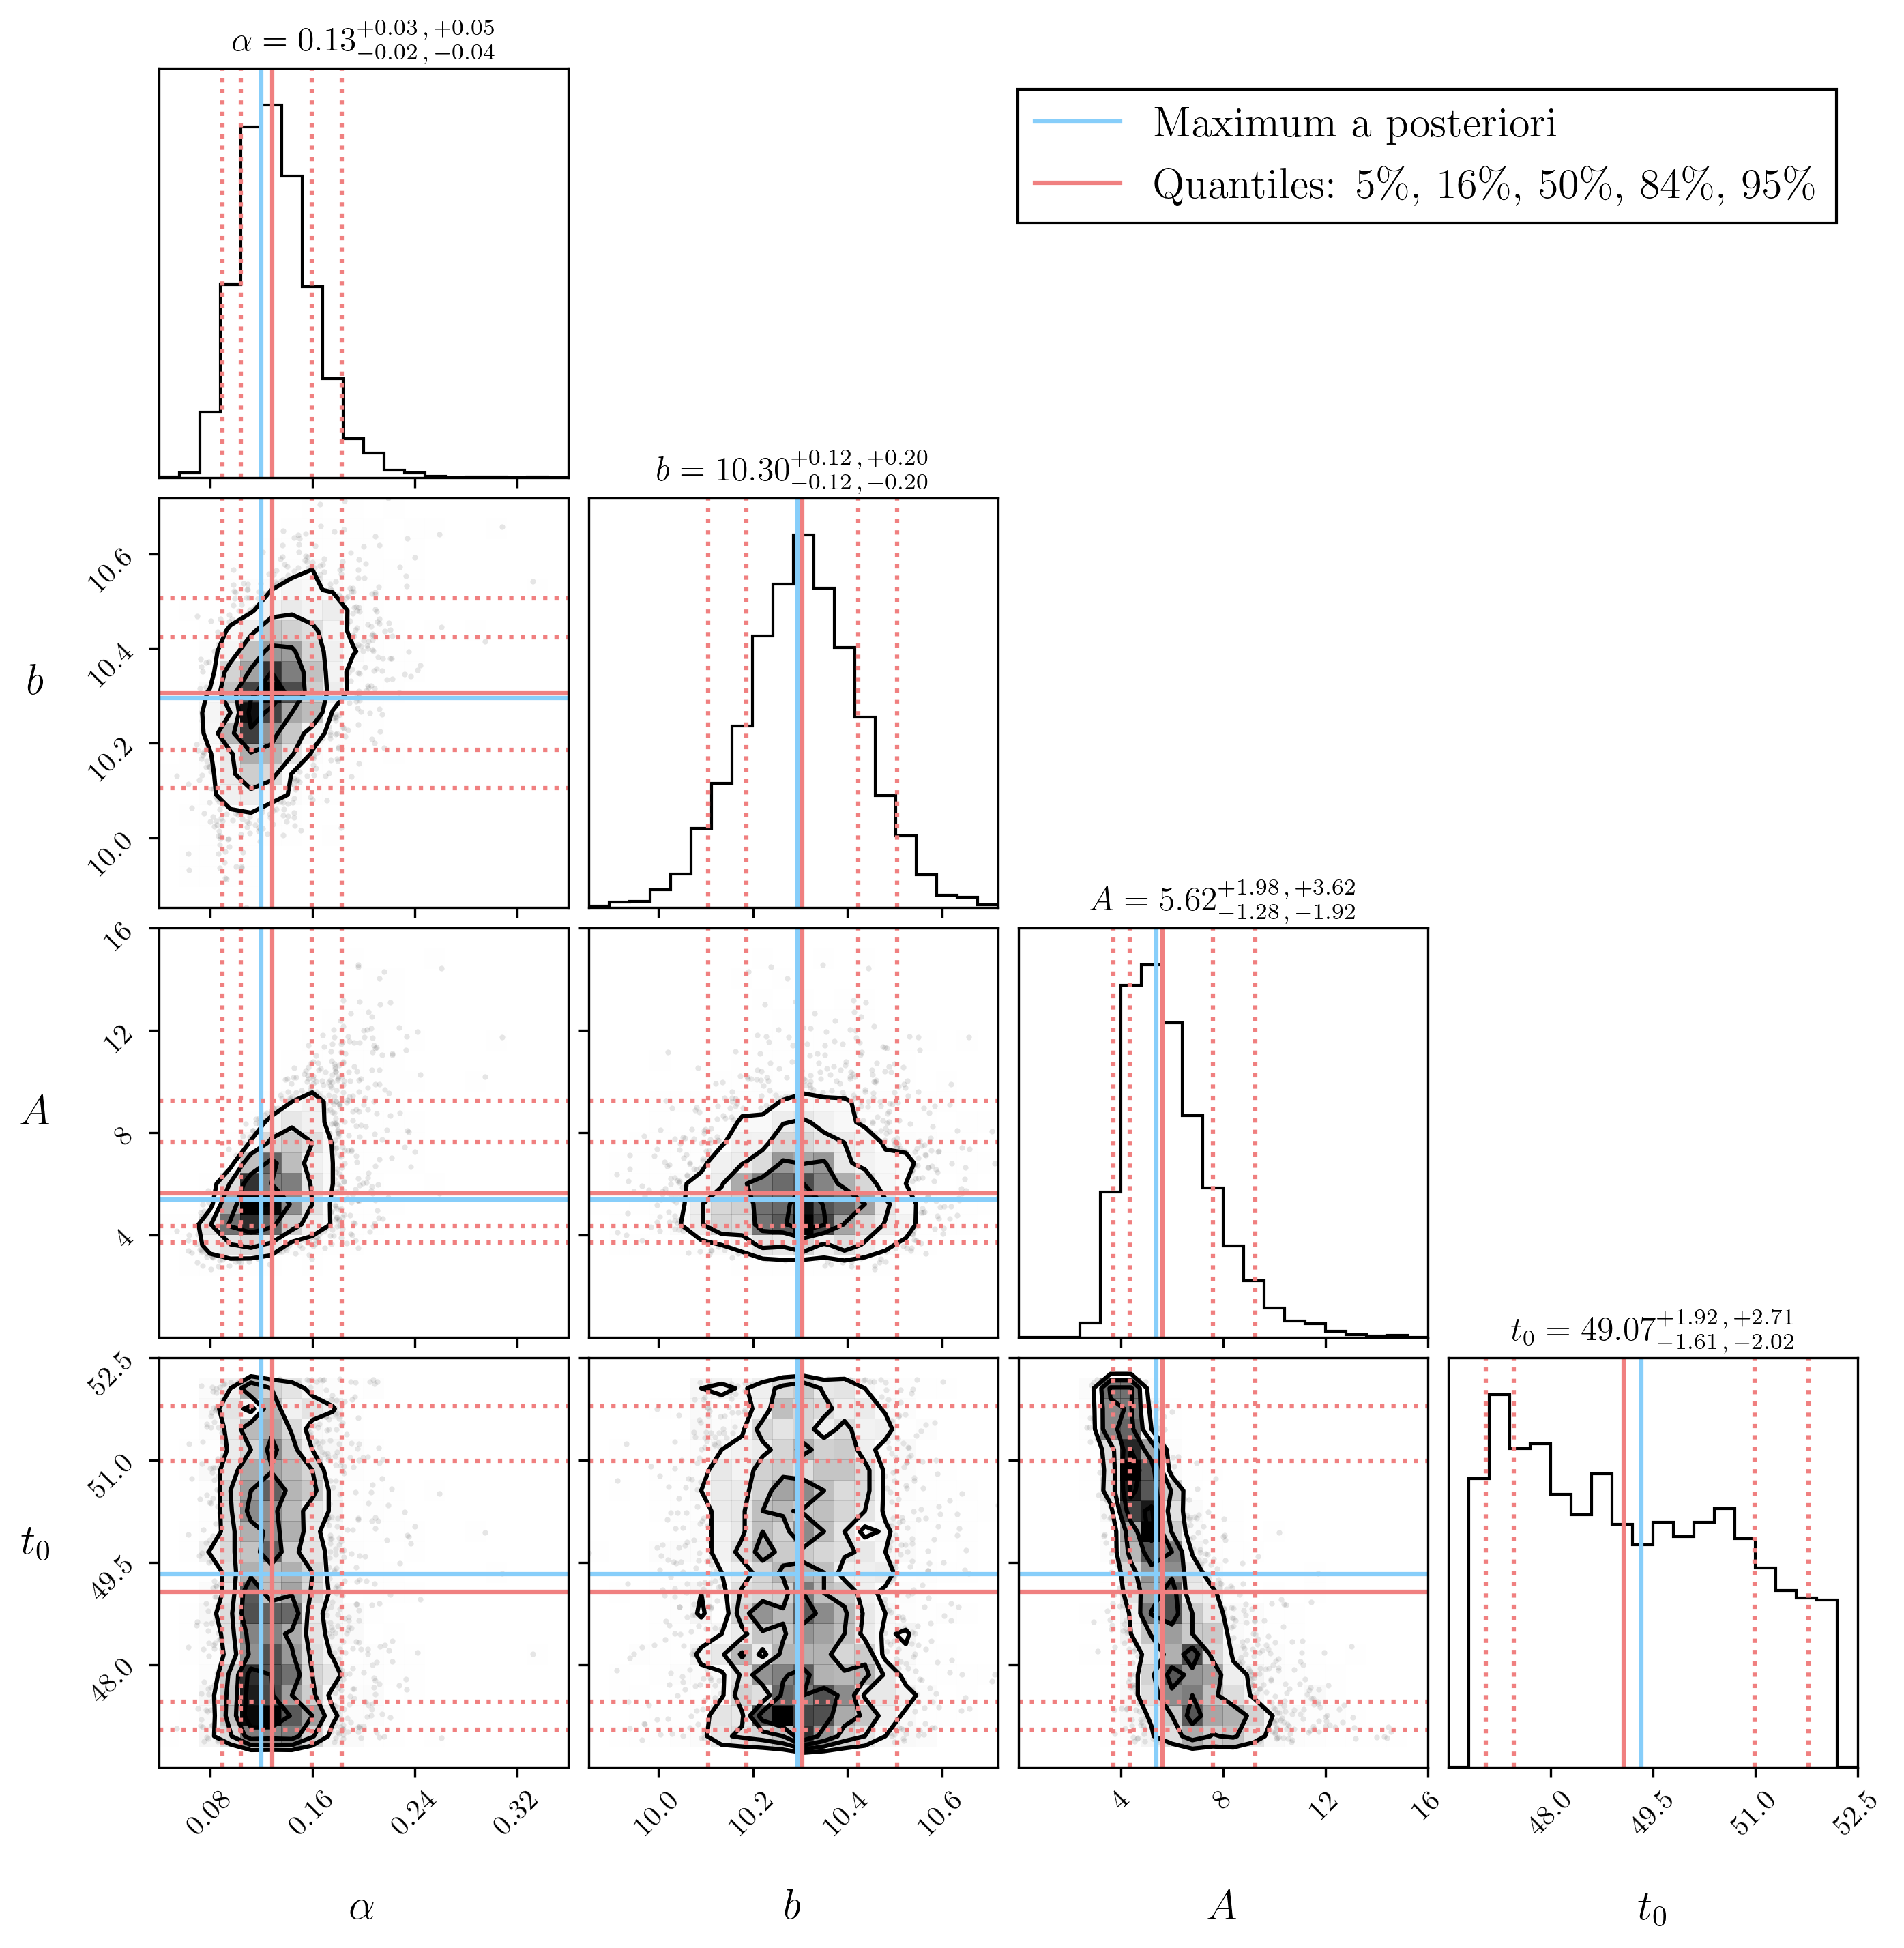

In [75]:
import corner

fontsize=15

fig = corner.corner(           #, truths=[m_true, b_true, np.log(f_true)]
    MCMC_trace,
    labels       = ylabels, 
    # quantiles    = [0.05, 0.16, 0.5, 0.84, 0.95],
    fontsize     = 15,
    verbose      = False,
    show_titles  = False, # note: title_fmt (string) = template for titles with quantiles; note: title_kwargs (dict)
    title_kwargs = {'fontsize':fontsize},
    label_kwargs = {'fontsize':fontsize, 'rotation':'horizontal'}, #, 'labelpad':20}
    range        = [(0.04,0.36), 1., (0.,16.), (46.5,52.5)]
)

ax = np.array(fig.axes).reshape((n_dim, n_dim))

# note: of the (n_dim, n_dim) axes, the plots are only those under (including) the diagonal.

quantiles = np.zeros((5,n_dim))
for i in range(n_dim):
    quantiles[:,i] = corner.quantile(MCMC_trace[:,i], q=[0.05, 0.16, 0.5, 0.84, 0.95])

print(quantiles)

par_name = [r'\alpha', 'b', 'A', 't_0']

for i in range(n_dim):
    titles = '$' + par_name[i] + '=' + \
             '{:.2f}'.format(quantiles[2,i]) + r'^{+' + \
             '{:.2f}'.format(quantiles[3,i] - quantiles[2,i]) + r'\, , \,+' + \
             '{:.2f}'.format(quantiles[4,i] - quantiles[2,i]) + r'}_{-'      + \
             '{:.2f}'.format(quantiles[2,i] - quantiles[1,i]) + r'\, , \,-'  + \
             '{:.2f}'.format(quantiles[2,i] - quantiles[0,i]) + r'}$'
    ax[i,i].set_title( titles )
    
# plot also the maximum a posteriori:

M = len(MCMC_trace[:,0])
MCMC_logpost = np.zeros(M)
for i in range(M):
    MCMC_logpost[i] = logposter( MCMC_trace[i,:], T, F, eF )

x_best = MCMC_trace[ np.argmax(MCMC_logpost) ,:] 

corner.overplot_lines(fig, x_best, color="lightskyblue")

ax[0,n_dim-1].plot([], [], marker='', color='lightskyblue', label='Maximum a posteriori')

# plot also the quantiles for each parameter:

corner.overplot_lines(fig, quantiles[2,:], color="lightcoral")
corner.overplot_lines(fig, quantiles[0,:], color="lightcoral", ls=':')
corner.overplot_lines(fig, quantiles[1,:], color="lightcoral", ls=':')
corner.overplot_lines(fig, quantiles[3,:], color="lightcoral", ls=':')
corner.overplot_lines(fig, quantiles[4,:], color="lightcoral", ls=':')

ax[0,n_dim-1].plot([], [], marker='', color='lightcoral', label='Quantiles: 5\%, 16\%, 50\%, 84\%, 95\%')



ax[0,n_dim-1].legend(title_fontsize=fontsize, fontsize=fontsize, frameon=True, framealpha=1, fancybox=False, edgecolor='black', )

# corner.overplot_points(figure, value1[None], marker="s", color="lightskyblue")
    
# fig.savefig('L11_Corner_Plot_Max.pdf', bbox_inches='tight')

(100, 4)


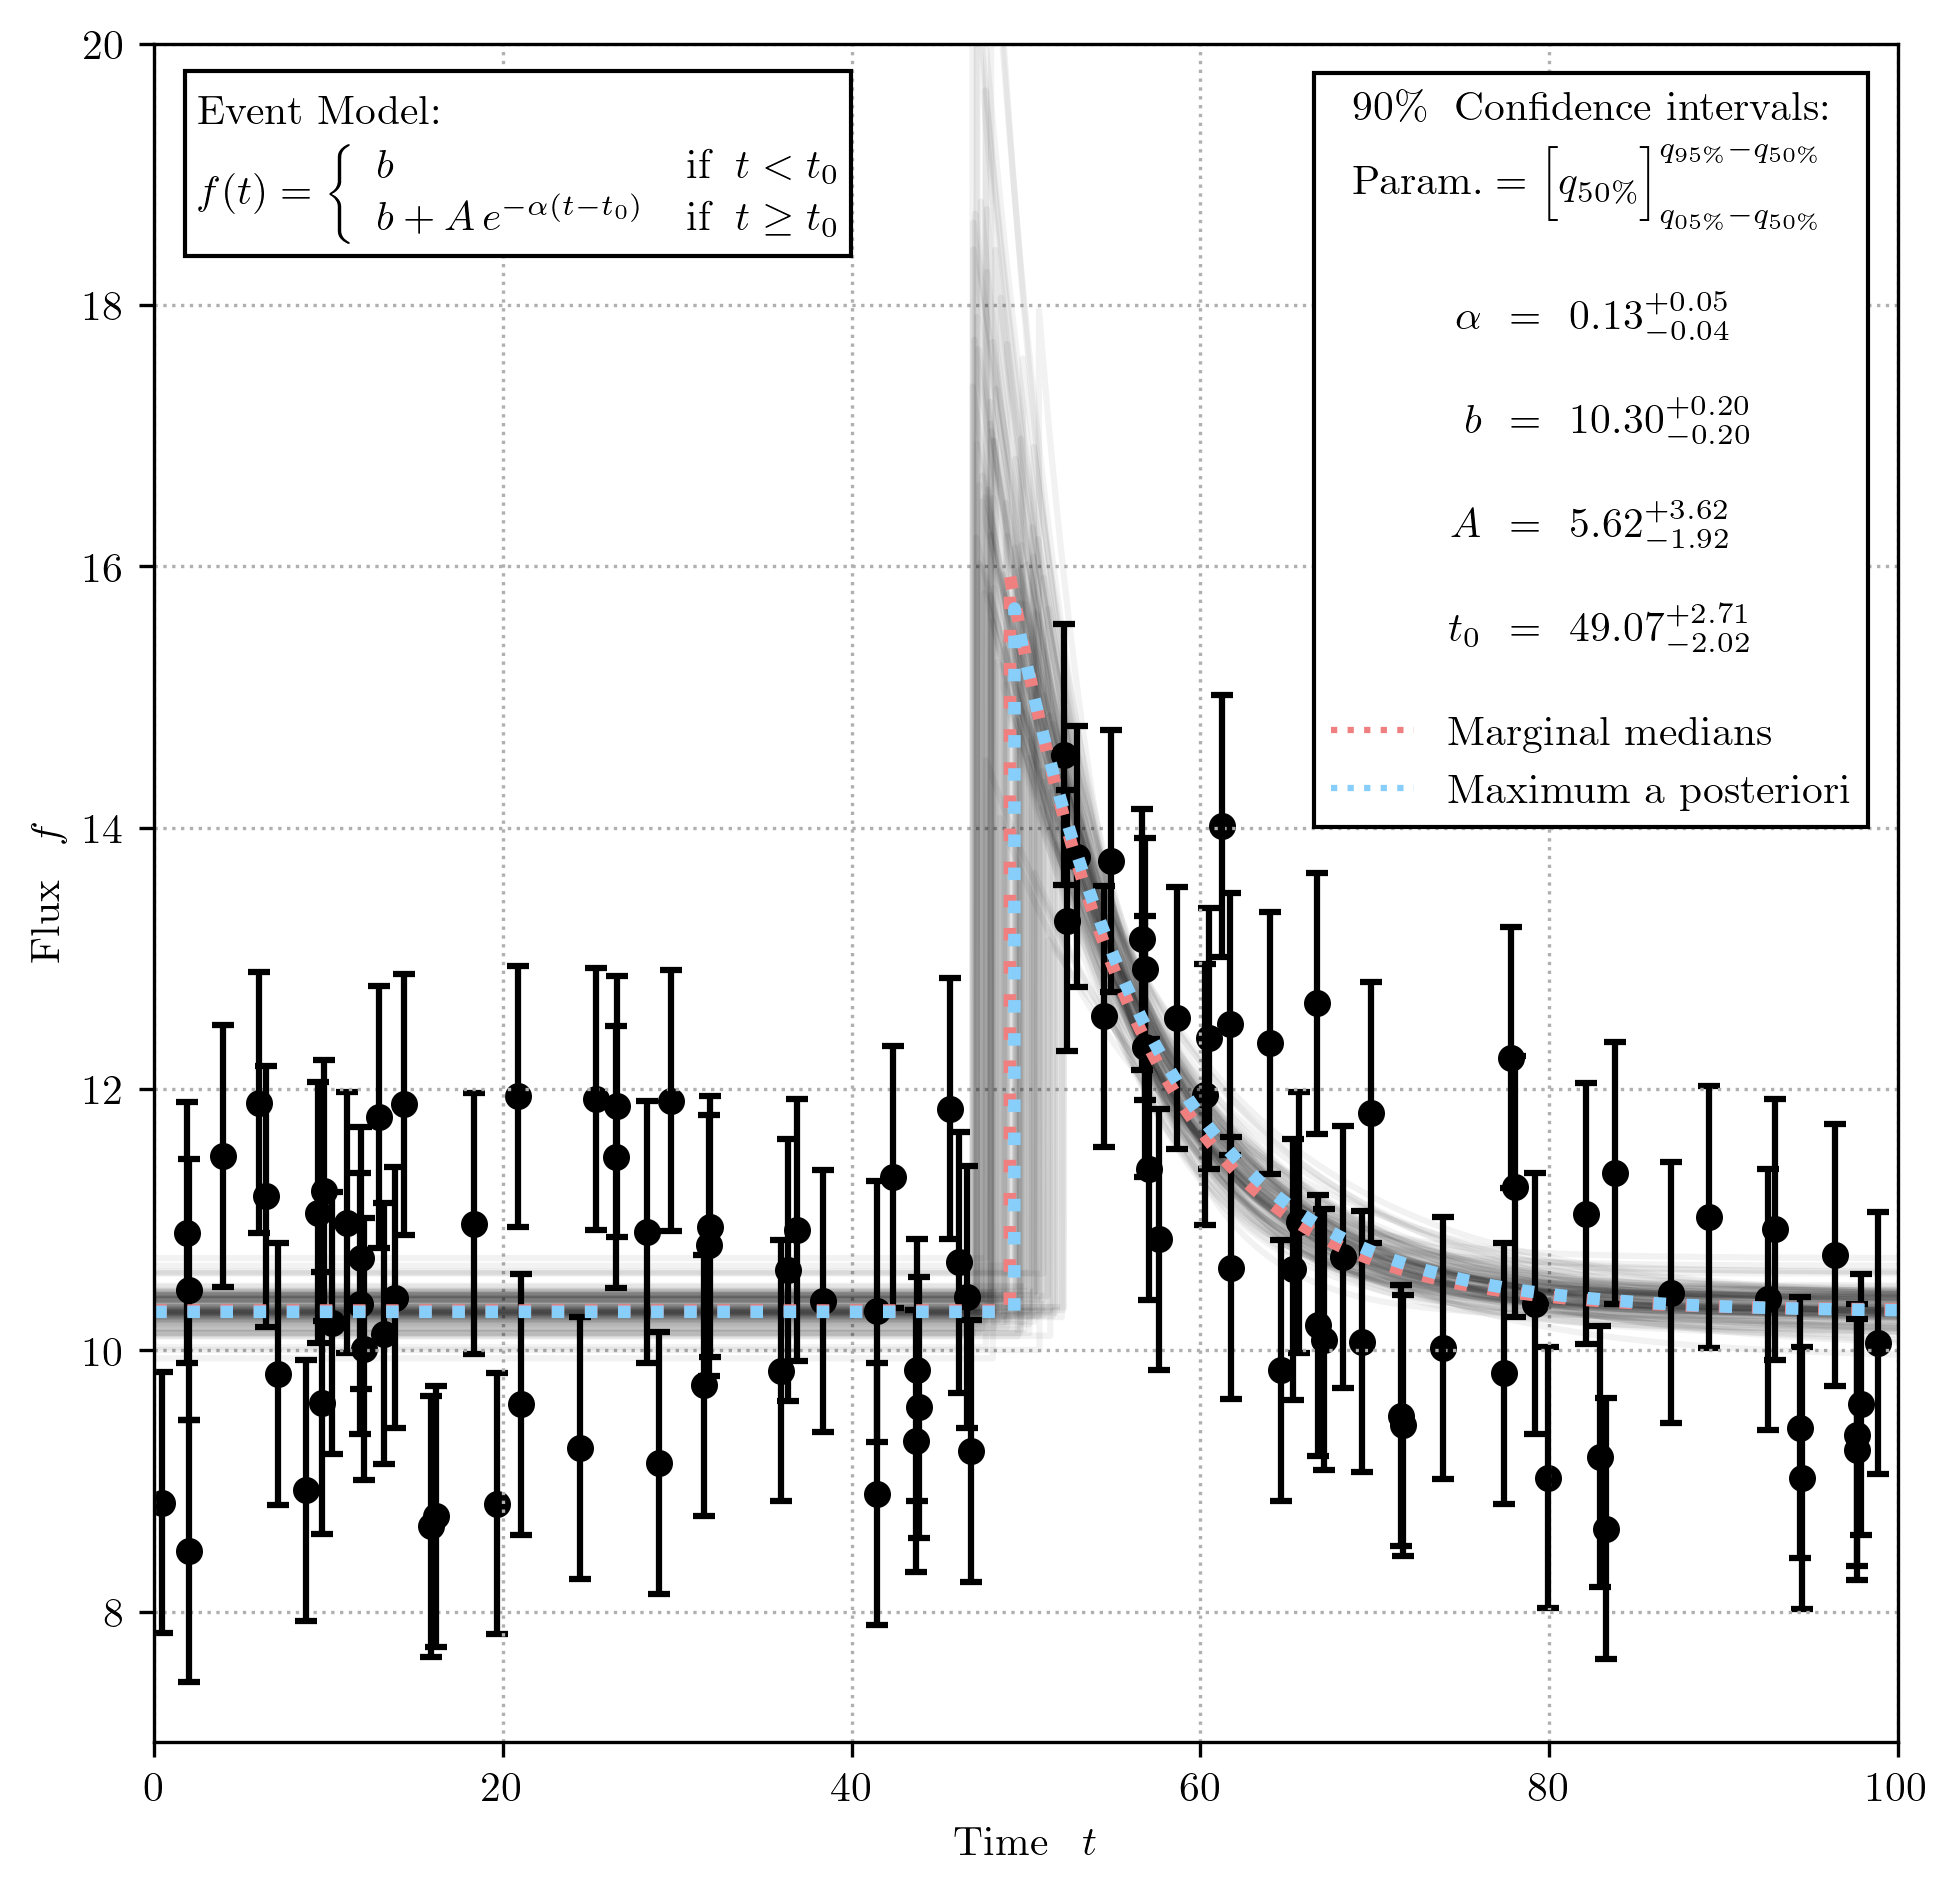

In [78]:
# Plot results over the data

fig , ax = plt.subplots(figsize=(7.5,7.5))

fontsize = 10

ax.set_xlim(0,100)
ax.set_ylim(7,20)
ax.grid(ls=':')

# ax.set_title(r'Event Model: \quad' + latexfunc + '\n', fontsize=15)
ax.set_xlabel(r'Time \, $t$', fontsize=fontsize)
ax.set_ylabel(r'Flux \, $f$', fontsize=fontsize) #, rotation='horizontal', labelpad=30)

# select 100 random [a,b,A,t0] from the MCMC sample:

n_rand = 100
MCMC_100 = MCMC_trace[ np.random.choice( len(MCMC_trace[:,0]) , size=n_rand, replace=False) , :]
print(MCMC_100.shape)

# plot the function "event" f(t) for these 100 tuples of parameters:

t_lin = np.linspace(0, 100, 10000)

for i in range(n_rand):
    y_lin = event(MCMC_100[i,:], t_lin)
    ax.plot(t_lin, y_lin, color='black', alpha=0.05)
    
# plot the original data:

for i in range(len(T)):                                                       #for t, f, ef in zip(T, F, eF):
    ax.vlines(T[i], ymin=F[i]-eF[i], ymax=F[i]+eF[i], color='black' )          #ax.vlines( t, ymin=t-ef, ymax=t+ef)
ax.scatter(T, F + eF, color='black', s=30, marker='_')
ax.scatter(T, F - eF, color='black', s=30, marker='_')
ax.scatter(T, F, color='black', s=30, marker='o') # , label='')

# plot the median and 90% credible region of the marginalized distribution: (done something similar above)

legend_title  = r'90\%' + '\; Confidence intervals:' + '\n' + 'Param.'
legend_title += r'$ \; = \Big[ q_{50\%} \Big]^{ q_{95\%} - q_{50\%}}_{ q_{05\%} - q_{50\%}}  $' + '\n'
label_results = '$' + r'\begin{array}{rcl}'

for i in range(n_dim):
    label_results += par_name[i] + r'\!&\! = \!&\!' + \
             '{:2.2f}'.format(quantiles[2,i]) + r'^{+' + \
             '{:1.2f}'.format(quantiles[4,i] - quantiles[2,i]) + r'}_{-'      + \
             '{:1.2f}'.format(quantiles[2,i] - quantiles[0,i]) + r'}' + r'\\ \\'
    
label_results += r'\end{array} $' + '\n'

ax.scatter( [], [], marker='', label=label_results)

# plot also the best fit curve computed with the medians:

y_lin = event(quantiles[2,:], t_lin)
ax.plot(t_lin, y_lin, color='lightcoral', alpha=1., ls=':', lw=3)

# plot also the best fit curve computed with the maximum a posteriori:

M = len(MCMC_trace[:,0])
MCMC_logpost = np.zeros(M)
for i in range(M):
    MCMC_logpost[i] = logposter( MCMC_trace[i,:], T, F, eF )

x_best = MCMC_trace[ np.argmax(MCMC_logpost) ,:] 
    
y_lin = event(x_best, t_lin)
ax.plot(t_lin, y_lin, color='lightskyblue', alpha=1., ls=':', lw=3)

ax.plot([], [], ls=':', color='lightcoral', label='Marginal medians')
ax.plot([], [], ls=':', color='lightskyblue', label='Maximum a posteriori')

# Plot the 'title' with the functional form of the transient event model

ax.legend(title=legend_title, 
          title_fontsize=fontsize, 
          fontsize=fontsize, 
          frameon=True, 
          framealpha=1, 
          fancybox=False, 
          edgecolor='black', 
          # handlelength=0, 
          # handletextpad=0,
          loc='upper right',
          bbox_to_anchor=(0.995,0.995)
         )

props = dict(boxstyle='square', facecolor='white', alpha=1.)

string = ax.text(0.025, 0.995, 
                 '\n' + r'Event Model:' + '\n' + latexfunc, 
                 transform=ax.transAxes, 
                 fontsize=fontsize,
                 verticalalignment='top', 
                 horizontalalignment='left', 
                 bbox=props
                )




# fig.savefig('L11_Final_Result_Fit_Max.pdf', bbox_inches='tight')

In [77]:
I_m_checking_the_sodding_axes = '''
print(ax.shape)
for i in range(4):
    for j in range(4):
        ax[i,j].scatter([],[], marker='', label='({:d},{:d})'.format(i,j))
        ax[i,j].legend()
'''

old_string = '''
string = ax.text(0.5, 1.105, 
                 r'Event Model: \quad' + latexfunc, 
                 transform=ax.transAxes, 
                 fontsize=fontsize,
                 verticalalignment='top', 
                 horizontalalignment='center', 
                 bbox=props
                )
'''